In [1]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution
from variables_config import (
    base_dir, input_dir, redshift_values, lf_data_dir,
    colour_data_dir, uvlf_limits, uvlf_nbins, colour_limits,
    colour_nbins, NUV_mag_lim, FUV_mag_lim, mag_limits, filters
)

# directories including redshift subdirectories
for category in ["attenuated", "intrinsic"]:
    for filters, path in lf_data_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)
            
    for filters, path in colour_data_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)


In [2]:
def get_intrinsic_uvlf(sim_name, snap, filters):
    """Get rest-frame luminosity function for given filters"""
    photo = get_photometry(
        sim_name=sim_name,
        spec_type="intrinsic",
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=filters,
        photo_dir=input_dir
    )
    return photo

def get_safe_name(name, filter_system_only=False):
    """
    Convert string to path-safe version and/or extract filter system.
    
    Args:
        name: String to process (e.g., "GALEX FUV" or "UV1500")
        filter_system_only: If True, returns only the filter system (e.g., "GALEX" or "UV")
    
    Returns:
        Processed string (e.g., "GALEX_FUV" or "GALEX")
    """
    # Replace spaces with underscores
    safe_name = name.replace(' ', '_')
    
    # If we only want the filter system, return the first part
    if filter_system_only:
        return safe_name.split('_')[0]
    
    return safe_name

def get_colour_dist(photo, filtA, filtB, mag_limits=None):
    """
    Get colour distribution with optional magnitude limits.
    A wrapper around get_colour_distribution that handles magnitude limits consistently.
    
    Args:
        photo: Photometry data dictionary
        filtA: First filter name
        filtB: Second filter name
        mag_limits: Optional dictionary of magnitude limits for each filter
    """
    if mag_limits:
        # Create magnitude masks if limits provided
        combined_mask = np.ones(len(photo[filtA]), dtype=bool)
        for band in [filtA, filtB]:
            if band in mag_limits:
                combined_mask &= (photo[band] < mag_limits[band])
    else:
        combined_mask = None
        
    colour_dist, bin_lims = get_colour_distribution(
        photo,
        filtA,
        filtB,
        *colour_limits,
        n_bins=colour_nbins,
        mask=combined_mask
    )
    return colour_dist, bin_lims



Processing intrinsic data...

Processing attenuated data...


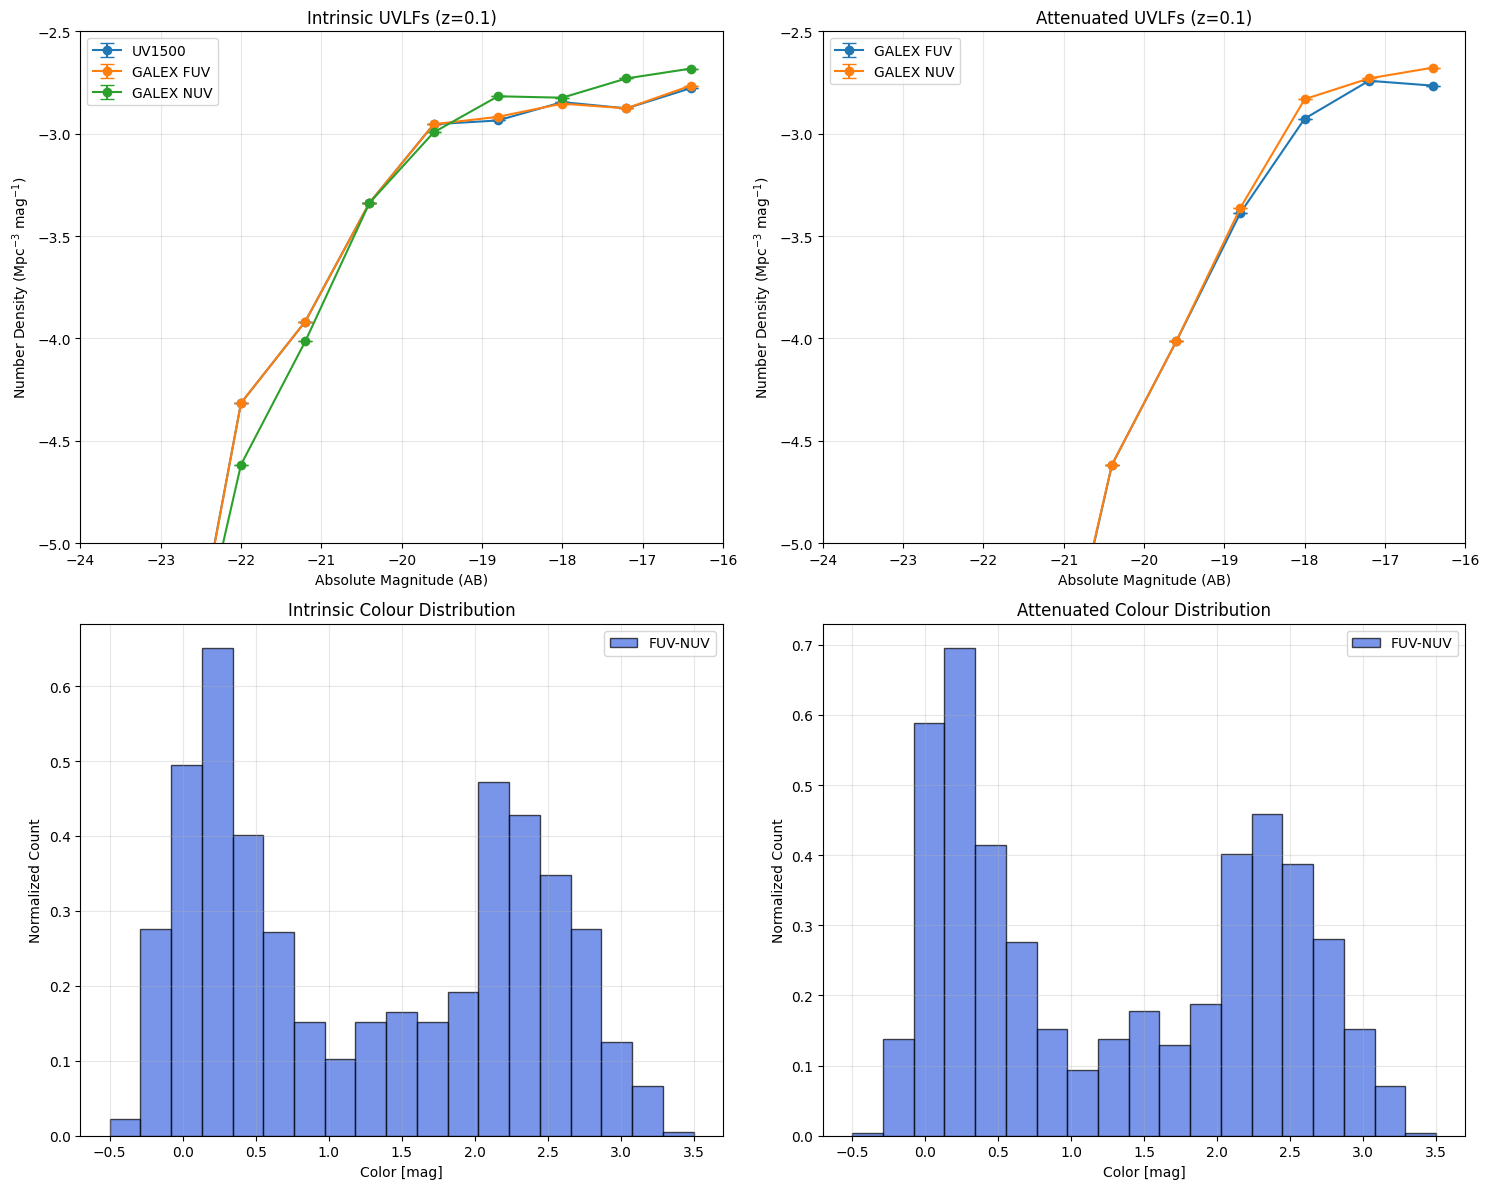

In [3]:
def test_single_file(sim_name, snap, intrinsic_bands=None, attenuated_bands=None, colour_pairs=None):
    """
    Test processing for a single file with flexible band combinations.
    
    Args:
        sim_name: Name of simulation file to process
        snap: Snapshot number
        intrinsic_bands: List of bands for intrinsic processing (default: ["UV1500", "GALEX FUV", "GALEX NUV"])
        attenuated_bands: List of bands for attenuated processing (default: ["GALEX FUV", "GALEX NUV"])
        colour_pairs: List of tuples containing band pairs for colors (default: [("GALEX FUV", "GALEX NUV")])
    """
    # Set default values if not provided
    if intrinsic_bands is None:
        intrinsic_bands = ["UV1500", "GALEX FUV", "GALEX NUV"]
    if attenuated_bands is None:
        attenuated_bands = ["GALEX FUV", "GALEX NUV"]
    if colour_pairs is None:
        colour_pairs = [("GALEX FUV", "GALEX NUV")]
    
    results = {}
    
    # Process intrinsic data
    print("\nProcessing intrinsic data...")
    rest_photo = get_photometry(
        sim_name=sim_name,
        spec_type="intrinsic",
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=intrinsic_bands,
        photo_dir=input_dir
    )
    
    # Calculate intrinsic UVLFs
    rest_uvlfs = {}
    for band in intrinsic_bands:
        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
            rest_photo,
            band,
            *uvlf_limits,
            n_bins=uvlf_nbins
        )
        rest_uvlfs[band] = (phi, phi_sigma, hist, bin_lims)
    
    # Calculate intrinsic colours
    rest_colours = {}
    for band1, band2 in colour_pairs:
        if band1 in rest_photo and band2 in rest_photo:
            colour_dist, bin_lims = get_colour_dist(
                rest_photo, 
                band1,
                band2,
                mag_limits=mag_limits
            )
            color_name = f"{band1.split()[-1]}-{band2.split()[-1]}"
            rest_colours[color_name] = (colour_dist, bin_lims)
    
    # Process attenuated data
    print("\nProcessing attenuated data...")
    att_photo = get_photometry(
        sim_name=sim_name,
        spec_type="attenuated",
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=attenuated_bands,
        photo_dir=input_dir
    )
    
    # Calculate attenuated UVLFs
    att_uvlfs = {}
    for band in attenuated_bands:
        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
            att_photo,
            band,
            *uvlf_limits,
            n_bins=uvlf_nbins
        )
        att_uvlfs[band] = (phi, phi_sigma, hist, bin_lims)
    
    # Calculate attenuated colours
    att_colours = {}
    for band1, band2 in colour_pairs:
        if band1 in att_photo and band2 in att_photo:
            colour_dist, bin_lims = get_colour_dist(
                att_photo, 
                band1,
                band2,
                mag_limits=mag_limits
            )
            color_name = f"{band1.split()[-1]}-{band2.split()[-1]}"
            att_colours[color_name] = (colour_dist, bin_lims)
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot intrinsic UVLFs
    for band, (phi, phi_sigma, hist, bin_lims) in rest_uvlfs.items():
        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
        ax1.errorbar(bin_centers, phi, yerr=phi_sigma, 
                    fmt='o-', label=band, capsize=5)
    ax1.set_ylim(-5, -2.5)
    ax1.set_xlim(*uvlf_limits)
    ax1.set_xlabel('Absolute Magnitude (AB)')
    ax1.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
    ax1.set_title(f'Intrinsic UVLFs (z={redshift_values[snap]["redshift"]})')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot attenuated UVLFs
    for band, (phi, phi_sigma, hist, bin_lims) in att_uvlfs.items():
        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
        ax2.errorbar(bin_centers, phi, yerr=phi_sigma, 
                    fmt='o-', label=band, capsize=5)
    ax2.set_ylim(-5, -2.5)
    ax2.set_xlim(*uvlf_limits)
    ax2.set_xlabel('Absolute Magnitude (AB)')
    ax2.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
    ax2.set_title(f'Attenuated UVLFs (z={redshift_values[snap]["redshift"]})')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot intrinsic colours
    for colour_name, (dist, bins) in rest_colours.items():
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax3.hist(bin_centers, bins=bins, weights=dist,
                alpha=0.7, color='royalblue', edgecolor='black', label=colour_name)
    ax3.set_xlabel('Color [mag]')
    ax3.set_ylabel('Normalized Count')
    ax3.set_title('Intrinsic Colour Distribution')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot attenuated colours
    for colour_name, (dist, bins) in att_colours.items():
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax4.hist(bin_centers, bins=bins, weights=dist,
                alpha=0.7, color='royalblue', edgecolor='black', label=colour_name)
    ax4.set_xlabel('Color [mag]')
    ax4.set_ylabel('Normalized Count')
    ax4.set_title('Attenuated Colour Distribution')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'intrinsic': {
            'photo': rest_photo,
            'uvlfs': rest_uvlfs,
            'colours': rest_colours
        },
        'attenuated': {
            'photo': att_photo,
            'uvlfs': att_uvlfs,
            'colours': att_colours
        }
    }

if __name__ == "__main__":
    # Test with default values
    results = test_single_file(sim_name="1P_p1_0", snap="086")
    
    # Or test with specific combinations
    # results = test_single_file(
    #     sim_name="1P_p1_0",
    #     snap="086",
    #     intrinsic_bands=["UV1500", "GALEX FUV", "GALEX NUV"],
    #     attenuated_bands=["GALEX FUV", "GALEX NUV"],
    #     colour_pairs=[("GALEX FUV", "GALEX NUV")]
    # )

In [4]:
def process_data(category, bands, colour_pairs=None):
    """Process data for any combination of bands and color pairs"""
    photo_files = [f for f in os.listdir(input_dir) if f.endswith('_photometry.hdf5')]
    
    for filename in photo_files:
        sim_name = filename.replace('IllustrisTNG_', '').replace('_photometry.hdf5', '')
        print(f"\nProcessing {sim_name}")
        
        for snap, redshift_info in redshift_values.items():
            print(f"  Processing z={redshift_info['label']}")
            
            # Get photometry
            photo = get_photometry(
                sim_name=sim_name,
                spec_type="intrinsic" if category == "intrinsic" else "attenuated",
                snap=snap,
                sps="BC03",
                model="IllustrisTNG",
                filters=bands,
                photo_dir=input_dir
            )
            
            # Process UVLFs
            for band in bands:
                phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                    photo,
                    band,
                    *uvlf_limits,
                    n_bins=uvlf_nbins
                )
                
                # Save UVLF
                bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                uvlf_df = pd.DataFrame({
                    'magnitude': bin_centers,
                    'phi': phi,
                    'phi_sigma': phi_sigma,
                    'hist': hist
                })
                
                # Get filter system and create output directory
                filter_system = get_safe_name(band, filter_system_only=True)
                spec_type = "intrinsic" if category == "intrinsic" else "attenuated"
                
                output_dir = os.path.join(lf_data_dir[category][filter_system],
                                        redshift_info['label'])
                os.makedirs(get_safe_name(output_dir), exist_ok=True)
                
                # Use get_safe_name for the band in the filename
                uvlf_filename = f"UVLF_{sim_name}_{get_safe_name(band)}_{redshift_info['label']}_{spec_type}.txt"
                uvlf_df.to_csv(os.path.join(get_safe_name(output_dir), uvlf_filename), 
                             index=False, sep='\t')
            
            # Process colours if pairs provided
            if colour_pairs:
                for band1, band2 in colour_pairs:
                    if band1 in photo and band2 in photo:
                        # Set magnitude limits for GALEX bands
                        mag_limits = {
                            "GALEX FUV": FUV_mag_lim,
                            "GALEX NUV": NUV_mag_lim
                        }
                        
                        # Calculate color distribution
                        colour_dist, bin_lims = get_colour_dist(
                            photo,
                            band1,
                            band2,
                            mag_limits=mag_limits
                        )
                        
                        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                        colour_df = pd.DataFrame({
                            'colour': bin_centers,
                            'distribution': colour_dist
                        })

                        # Get filter system and create output directory
                        filter_system = get_safe_name(band1, filter_system_only=True)
                        output_dir = os.path.join(colour_data_dir[category][filter_system],
                                                redshift_info['label'])
                        os.makedirs(get_safe_name(output_dir), exist_ok=True)
                        
                        # Create standardized filename using get_safe_name for band names
                        color_name = f"{get_safe_name(band1).split('_')[-1]}-{get_safe_name(band2).split('_')[-1]}"
                        spec_type = "intrinsic" if category == "intrinsic" else "attenuated"
                        colour_filename = f"Colour_{sim_name}_{color_name}_{redshift_info['label']}_{spec_type}.txt"
                        colour_df.to_csv(os.path.join(get_safe_name(output_dir), colour_filename),
                                       index=False, sep='\t')

            print(f"    Completed processing for z={redshift_info['label']}")

def process_all_data():
    """Process all combinations of data types and bands"""
    # Define band combinations
    galex_bands = ["GALEX FUV", "GALEX NUV"]
    uv_bands = ["UV1500"]
    galex_colours = [("GALEX FUV", "GALEX NUV")]
    
    # Process all combinations
    print("Processing attenuated GALEX data...")
    process_data("attenuated", galex_bands, galex_colours)
    
    print("\nProcessing intrinsic GALEX data...")
    process_data("intrinsic", galex_bands, galex_colours)
    
    print("\nProcessing intrinsic UV data...")
    process_data("intrinsic", uv_bands)

if __name__ == "__main__":
    # Process all data
    process_all_data()
    
    # Or process specific combinations
    # process_data(
    #     category="intrinsic",
    #     bands=["GALEX FUV", "GALEX NUV"],
    #     colour_pairs=[("GALEX FUV", "GALEX NUV")]
    # )

Processing attenuated GALEX data...

Processing 1P_p7_2
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p9_n1
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p14_n2
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p23_n1
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed proce